In [1]:
%matplotlib inline
import torch
from torchvision import transforms
from torchvision import datasets
import os
import matplotlib.pyplot as plt
from torch import nn
from torch import optim
import torch.nn.functional as F
from torch.autograd import Variable

[Variational Auto-Encoder](https://github.com/yunjey/pytorch-tutorial/tree/master/tutorials/03-advanced/variational_auto_encoder) 主要参考这个仓库的代码

In [2]:
# torch.chunk?

In [3]:
batch_size = 100

In [4]:
def to_var(x):
    if torch.cuda.is_available():
        x = x.cuda()
    return Variable(x)

In [5]:
data_train = datasets.MNIST(root=os.path.expanduser('~/Data/pytorch/'), train=True, transform=transforms.ToTensor(), download=True)

In [6]:
data_train_loader = torch.utils.data.DataLoader(dataset=data_train, batch_size=batch_size, shuffle=True)

In [7]:
class VAE(nn.Module):
    def __init__(self, image_size=28*28, h_dim=400, z_dim=20):
        super(VAE, self).__init__()
        self.encoder = nn.Sequential(
            nn.Linear(in_features=image_size, out_features=h_dim),
            nn.LeakyReLU(0.2),
            nn.Linear(in_features=h_dim, out_features=z_dim*2) # 2表示mu和log_var
        )
        self.decoder = nn.Sequential(
            nn.Linear(in_features=z_dim, out_features=h_dim),
            nn.ReLU(),
            nn.Linear(in_features=h_dim, out_features=image_size),
            nn.Sigmoid()
        )
        
    def resample(self, mu, log_var):
        eps = to_var(torch.randn((mu.size(0), mu.size(1))))
        z = mu + eps*torch.exp(log_var/2)
        return z
        
    def forward(self, x):
        h = self.encoder(x)
        mu, log_var = torch.chunk(h, chunks=2, dim=1)
        z = self.resample(mu, log_var)
        out = self.decoder(z)
        return out, mu, log_var

In [8]:
vae = VAE()
if torch.cuda.is_available():
    vae.cuda()

In [9]:
optimizer = optim.Adam(vae.parameters(), lr=0.001)

In [10]:
# 固定参数，用来调试
fixed_x, _ = next(iter(data_train_loader))
fixed_x_flatten = fixed_x.view(batch_size, -1)
print(fixed_x_flatten.shape)
fixed_x_var = to_var(fixed_x_flatten)

torch.Size([100, 784])


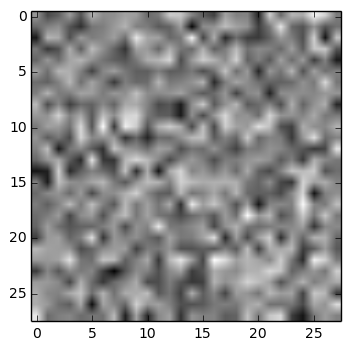

In [11]:
# 训练前
fixed_x_pred_var, _, _ = vae(fixed_x_var)
fixed_x_pred_var_np = fixed_x_pred_var.data.cpu().numpy().reshape(-1, 28, 28)
fixed_x_pred_var_0_np = fixed_x_pred_var_np[0, :, :]
# print(fixed_x_pred_var_np.shape)
plt.imshow(fixed_x_pred_var_0_np, cmap='gray')

In [12]:
for epoch in range(10):
    for data_train_index, (data_images, _) in enumerate(data_train_loader):
#         print('data_train_index:', data_train_index)
#         print('data_images.shape:', data_images.shape)
        data_images_flatten = data_images.view(batch_size, -1)
        data_images_flatten_var = to_var(data_images_flatten)
        
        data_images_flatten_var_out, mu, log_var = vae(data_images_flatten_var)
        
        # 误差loss
        reconst_loss = F.binary_cross_entropy(data_images_flatten_var_out, data_images_flatten_var, size_average=False)
        kl_divergence = torch.sum(0.5 * (mu**2 + torch.exp(log_var) - log_var -1))
        total_loss = reconst_loss + kl_divergence
        
        optimizer.zero_grad()
        total_loss.backward()
        optimizer.step()
        
        if data_train_index%1000==0 and epoch%10==0:
            total_loss_np = total_loss.data.cpu().numpy()[0]
            print('total_loss_np:', total_loss_np)

('total_loss_np:', 54762.082)


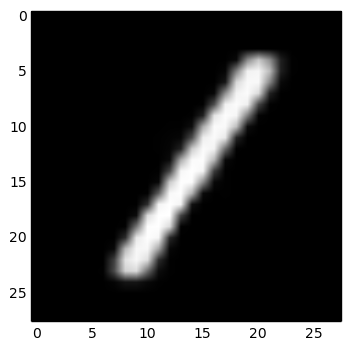

In [13]:
# 训练后
fixed_x_pred_var, _, _ = vae(fixed_x_var)
fixed_x_pred_var_np = fixed_x_pred_var.data.cpu().numpy().reshape(-1, 28, 28)
fixed_x_pred_var_0_np = fixed_x_pred_var_np[0, :, :]
# print(fixed_x_pred_var_np.shape)
plt.imshow(fixed_x_pred_var_0_np, cmap='gray')